In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
from os import system
from IPython.display import clear_output
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import phik 
import seaborn as sns
from phik import resources, report
from phik.report import plot_correlation_matrix
from itertools import combinations
import random
from tabulate import tabulate
from IPython.display import display, HTML

# this is PRAD not BRCA even though some of the variable names say BRCA

In [2]:
interest_gene= 'ITGA2'
correlation_method ='pearson'
gtex_gct_dataset = './gene_tpm_2017-06-05_v8_prostate.gct'
correlation_cutoff = 0.6
tcga_hiseq_dataset = 'TCGA.PRAD.sampleMap_HiSeqV2' 
tcga_hiseq_corresponding_sample_info = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGAXena/TCGA.PRAD.sampleMap/PRAD_clinicalMatrix'
opposing_corr_cutoff = 0.1


In [3]:
#functions for data processing
def gtex_data_processing(gtex_gct_dataset):
    unwanted_integrins = ['ITGB3BP','ITGB1BP1','ITGB5-AS1','ITGA9-AS1','ITGB1P1','ITGB2-AS1', 'ITGB1BP2','ITGB1BP3']
    gtex_breast_data_all=pd.read_csv(gtex_gct_dataset,sep='\t')
    gtex_breast_data_all=gtex_breast_data_all.T.copy()
    gtex_breast_data_all.columns=gtex_breast_data_all.iloc[2]
    df_int=gtex_breast_data_all.loc[(gtex_breast_data_all.index!='id')&(gtex_breast_data_all.index!='Name')&(gtex_breast_data_all.index!='Description')].astype('float').copy()
    #drop unwanted integrins    
    df_int=df_int.drop([undesired_integrin for undesired_integrin in df_int.columns if undesired_integrin in unwanted_integrins],axis=1)
    #drop duplicate gene names (if any) 
    df_int=df_int.loc[:,~df_int.columns.duplicated()]    
    return df_int

def tcga_data_processing(tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info):
    global tcga_brca_df, tcga_brca_sample_info
    unwanted_integrins = ['ITGB3BP','ITGB1BP1','ITGB5-AS1','ITGA9-AS1','ITGB1P1','ITGB2-AS1', 'ITGB1BP2','ITGB1BP3']    
    tcga_brca_df = pd.read_csv(tcga_hiseq_dataset, sep = '\t', index_col=0)
    #drop unwanted integrins    
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.isin(unwanted_integrins)]
    #drop duplicate gene names (if any)
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.duplicated()]    
    tcga_brca_sample_info = pd.read_csv(tcga_hiseq_corresponding_sample_info,sep="\t",index_col=0)
    #drop metastatic from main sample type data frame
    tcga_brca_sample_info = tcga_brca_sample_info[~(tcga_brca_sample_info.sample_type=='Metastatic')]

    #separate normal and primtum
    tcga_brca_normal_patients = tcga_brca_sample_info[tcga_brca_sample_info.sample_type=='Solid Tissue Normal']
    tcga_brca_primtum_patients = tcga_brca_sample_info[tcga_brca_sample_info.sample_type=='Primary Tumor']

    #drop index of samples not in tcga_brca_df
    tcga_brca_normal_patients=  tcga_brca_normal_patients.drop(non_match for non_match in tcga_brca_normal_patients.index.values if non_match not in tcga_brca_df.columns)
    tcga_brca_primtum_patients =tcga_brca_primtum_patients.drop(non_match for non_match in tcga_brca_primtum_patients.index.values if non_match not in tcga_brca_df.columns) 

    #make sure both normal and tumor patients match, and drop patients not in tcga_brca_df
    matched_patient_index_list=[]
    for patient in tcga_brca_primtum_patients.patient_id.values:
        if patient in tcga_brca_normal_patients.patient_id.values and patient in [patient_id.split('-')[2] for patient_id in tcga_brca_df.columns]:
            matched_patient_index_list.append(tcga_brca_sample_info[tcga_brca_sample_info.patient_id==patient].index.values)
    matched_patient_list=tcga_brca_sample_info.loc[[x for l in matched_patient_index_list for x in l]].copy()


    #separate normal and primary tumor
    normal_matched_patient_list=matched_patient_list[matched_patient_list.sample_type=='Solid Tissue Normal']
    primtum_matched_patient_list = matched_patient_list[matched_patient_list.sample_type=='Primary Tumor']

    #matched normal and primary tumor samples
    tcga_brca_df_normal_matched=tcga_brca_df[tcga_brca_df.columns[tcga_brca_df.columns.isin(normal_matched_patient_list.index.values)]]
    tcga_brca_df_primtum_matched=tcga_brca_df[tcga_brca_df.columns[tcga_brca_df.columns.isin(primtum_matched_patient_list.index.values)]]

    #test to see if normal and primary tumor patient IDs are a match
    for i in [patient_id.split('-')[2] for patient_id in tcga_brca_df_normal_matched.columns]:
        if i not in [patient_id.split('-')[2] for patient_id in tcga_brca_df_primtum_matched.columns]:
            print('trouble')
            
    #TCGA brca normal ALL
    tcga_brca_df_normal_all = tcga_brca_df.T.loc[tcga_brca_normal_patients.index.values].copy()
    # dataframe with all TCGA primary tumor samples (not necessarily matched)
    tcga_brca_df_primtum_all= tcga_brca_df.T.loc[tcga_brca_primtum_patients.index.values].copy()
    
    return {'tcga_brca_df_normal_matched':tcga_brca_df_normal_matched,
           'tcga_brca_df_primtum_matched':tcga_brca_df_primtum_matched,
           'tcga_brca_df_normal_all':tcga_brca_df_normal_all,
           'tcga_brca_df_primtum_all':tcga_brca_df_primtum_all}

def correlation_selected_gene(provided_dataset,interest_gene,correlation_method):
    dataset_corr = provided_dataset.corrwith(provided_dataset[interest_gene],method=correlation_method).drop(interest_gene)
    dataset_corr = dataset_corr.dropna(axis=0,how='any')
    idx = dataset_corr.index.drop_duplicates(keep=False)
    dataset_corr = dataset_corr.loc[idx]
    return dataset_corr
def pairwise_pearson_correlation(provided_dataset):
    #columns have to be variables and rows have to be observations
    pairwise_corr=pd.DataFrame(np.corrcoef(provided_dataset,rowvar=False),
                               columns=provided_dataset.columns,index=provided_dataset.columns)



In [4]:
#functions for counting
def count_genes_3_no_overlap(interest_gene,correlation_method,gtex_dataset,dataset2,dataset3):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    print('no overlap between datasets')
    dict_empty={}
    first_dataset_name = 'gtex_all'
    second_dataset_name= 'tcga_normal_all'
    third_dataset_name= 'tcga_primtum_all'
    names = [first_dataset_name,second_dataset_name,third_dataset_name]
    j=0
    for dataset in [gtex_dataset,dataset2,dataset3]:
        dataset=correlation_selected_gene(dataset,interest_gene,correlation_method)
        dict_empty[names[j]]=dataset.shape[0]
        j+=1
    dict_pd_df = pd.DataFrame(dict_empty,index=[f'corr_with_{interest_gene}'])
    return display(HTML(dict_pd_df.to_html()))    
def count_genes_same_3(interest_gene,correlation_method,gtex_dataset,dataset2,dataset3):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    gtex_dataset=correlation_selected_gene(gtex_dataset,interest_gene,correlation_method)
    dataset2=correlation_selected_gene(dataset2,interest_gene,correlation_method)
    dataset3=correlation_selected_gene(dataset3,interest_gene,correlation_method)
    common_gene_list= gtex_dataset.index.intersection(dataset2.index).intersection(dataset3.index)
    global new_dataset
    new_dataset = pd.concat([gtex_dataset[common_gene_list],
                             dataset2[common_gene_list],
                             dataset3[common_gene_list]],axis=1)
    first_dataset_name = 'gtex_all'
    second_dataset_name= 'tcga_normal_all'
    third_dataset_name= 'tcga_primtum_all'
    new_dataset.columns=[first_dataset_name,second_dataset_name,third_dataset_name]
    print("1st: common genes identified for all 3 datasets\n2nd: they were counted")
    dict_pd_df = pd.DataFrame(data=[[new_dataset.shape[0],new_dataset.shape[0],new_dataset.shape[0]]],
                             index=[f'corr_with_{interest_gene}_all_same_genes'],
                             columns=[first_dataset_name,second_dataset_name,third_dataset_name])
    return display(HTML(dict_pd_df.to_html()))
def count_high_corr_genes_no_overlap(interest_gene,correlation_method,correlation_cutoff,*processed_datasets):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    print('no overlap between datasets')
    dict_empty={}
    j=0
    for dataset in processed_datasets:
        dataset=correlation_selected_gene(dataset,interest_gene,correlation_method)
        dict_empty[input(f'insert name for {j+1}th dataset')]=dataset[dataset>=correlation_cutoff].shape[0]
        
        j+=1
    
    dict_pd_df = pd.DataFrame(dict_empty,index=[f'HIGHLY_correlated_with_{interest_gene}'])
    #return display(HTML(dict_pd_df.to_html()))
    return dict_pd_df
def cutoff_applied_togtex_2_high_both(interest_gene,correlation_method,correlation_cutoff,gtex_dataset,other_dataset):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    gtex_dataset=correlation_selected_gene(gtex_dataset,interest_gene,correlation_method)
    gtex_dataset = gtex_dataset[gtex_dataset>=correlation_cutoff]
    dataset2=correlation_selected_gene(other_dataset,interest_gene,correlation_method)
    common_gene_list= gtex_dataset.index.intersection(dataset2.index)
    global new_dataset    
    new_dataset = pd.concat([gtex_dataset[common_gene_list],dataset2[common_gene_list]],axis=1)
    first_dataset_name = 'gtex_cutoffmet'
    other_dataset_name=input('insert name for other dataset')
    new_dataset.columns=[first_dataset_name,other_dataset_name]
    print("1st: high cutoff applied to gtex dataset\n2nd: common genes identified with other dataset\n3rd: both datasets combined\n4th: High cutoff applied to non-gtex dataset")
    
    new_dataset = new_dataset[new_dataset[other_dataset_name]>=correlation_cutoff]
    dict_pd_df = pd.DataFrame(data=[[new_dataset.shape[0],new_dataset.shape[0]]],
                             index=[f'high_corr_with_{interest_gene}_both_same_genes'],
                             columns=[first_dataset_name,other_dataset_name])
    return dict_pd_df
def cutoff_applied_togtex_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,gtex_dataset,other_dataset):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    gtex_dataset=correlation_selected_gene(gtex_dataset,interest_gene,correlation_method)
    gtex_dataset = gtex_dataset[gtex_dataset>=correlation_cutoff]
    dataset2=correlation_selected_gene(other_dataset,interest_gene,correlation_method)
    common_gene_list= gtex_dataset.index.intersection(dataset2.index)
    global new_dataset    
    new_dataset = pd.concat([gtex_dataset[common_gene_list],dataset2[common_gene_list]],axis=1)
    first_dataset_name = 'gtex_cutoffmet'
    other_dataset_name=input('insert name for other dataset')
    new_dataset.columns=[first_dataset_name,other_dataset_name]
    print("1st: high cutoff applied to gtex dataset\n2nd: common genes identified with other dataset\n3rd: both datasets combined\n4th: low cutoff applied to non-gtex dataset")
    
    new_dataset = new_dataset[new_dataset[other_dataset_name]<=opposing_corr_cutoff]
    dict_pd_df = pd.DataFrame(data=[[new_dataset.shape[0],new_dataset.shape[0]]],
                             index=[f'corr_with_{interest_gene}_highgtex_low_other'],
                             columns=[first_dataset_name,other_dataset_name])
    return dict_pd_df
def cutoff_applied_totcga_2_high_both(interest_gene,correlation_method,correlation_cutoff,gtex_dataset,other_dataset):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    gtex_dataset=correlation_selected_gene(gtex_dataset,interest_gene,correlation_method)
    dataset2=correlation_selected_gene(other_dataset,interest_gene,correlation_method)
    dataset2 = dataset2[dataset2>=correlation_cutoff]
    common_gene_list= gtex_dataset.index.intersection(dataset2.index)
    global new_dataset    
    new_dataset = pd.concat([gtex_dataset[common_gene_list],dataset2[common_gene_list]],axis=1)
    first_dataset_name = 'gtex_all'
    other_dataset_name='tcga_primtum_all_cutoffmet'
    new_dataset.columns=[first_dataset_name,other_dataset_name]
    print("1st: high cutoff applied to tcga dataset\n2nd: common genes identified with gtex dataset\n3rd: both datasets combined\n4th: High cutoff applied to gtex dataset")

    new_dataset = new_dataset[new_dataset[first_dataset_name]>=correlation_cutoff]
    dict_pd_df = pd.DataFrame(data=[[new_dataset.shape[0],new_dataset.shape[0]]],
                             index=[f'high_corr_with_{interest_gene}_both_same_genes'],
                             columns=[first_dataset_name,other_dataset_name])
    return display(HTML(dict_pd_df.to_html()))
def cutoff_applied_totcga_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,gtex_dataset,other_dataset):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    gtex_dataset=correlation_selected_gene(gtex_dataset,interest_gene,correlation_method)
    dataset2=correlation_selected_gene(other_dataset,interest_gene,correlation_method)
    dataset2 = dataset2[dataset2>=correlation_cutoff]
    common_gene_list= gtex_dataset.index.intersection(dataset2.index)
    global new_dataset    
    new_dataset = pd.concat([gtex_dataset[common_gene_list],dataset2[common_gene_list]],axis=1)
    first_dataset_name = 'gtex_all'
    other_dataset_name='tcga_primtum_all_cutoffmet'
    new_dataset.columns=[first_dataset_name,other_dataset_name]
    print("1st: high cutoff applied to tcga dataset\n2nd: common genes identified with gtex dataset\n3rd: both datasets combined\n4th: low cutoff applied to gtex dataset")

    new_dataset = new_dataset[new_dataset[first_dataset_name]<=opposing_corr_cutoff]
    dict_pd_df = pd.DataFrame(data=[[new_dataset.shape[0],new_dataset.shape[0]]],
                             index=[f'corr_with_{interest_gene}_both_same_genes'],
                             columns=[first_dataset_name,other_dataset_name])
    return display(HTML(dict_pd_df.to_html()))

def cutoff_applied_togtex_3_high_all(interest_gene,correlation_method,correlation_cutoff,gtex_dataset,other_dataset,
                                    dataset3):
#dataset3 MUST BE tcga primtum all
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    gtex_dataset=correlation_selected_gene(gtex_dataset,interest_gene,correlation_method)
    gtex_dataset = gtex_dataset[gtex_dataset>=correlation_cutoff]
    dataset2=correlation_selected_gene(other_dataset,interest_gene,correlation_method)
    dataset3=correlation_selected_gene(dataset3,interest_gene,correlation_method)
    common_gene_list= (gtex_dataset.index.intersection(dataset2.index)).intersection(dataset3.index)
    global new_dataset    
    new_dataset = pd.concat([gtex_dataset[common_gene_list],
                             dataset2[common_gene_list],
                            dataset3[common_gene_list]],axis=1)
    first_dataset_name = 'gtex_cutoffmet'
    other_dataset_name='tcga_normal_all'
    dataset3_name = 'tcga_primtum_all'
    new_dataset.columns=[first_dataset_name,other_dataset_name,dataset3_name]
    print("1st: high cutoff applied to gtex dataset\n2nd: common genes identified with other datasets\n3rd: all datasets combined\n4th: High cutoff applied to non-gtex datasets")
    
    new_dataset = new_dataset[(new_dataset[other_dataset_name]>=correlation_cutoff) & (new_dataset[dataset3_name]>=correlation_cutoff)]
    dict_pd_df = pd.DataFrame(data=[[new_dataset.shape[0],new_dataset.shape[0],new_dataset.shape[0]]],
                             index=[f'high_corr_with_{interest_gene}_all_same_genes'],
                             columns=[first_dataset_name,other_dataset_name,dataset3_name])
    return dict_pd_df



In [5]:
#organize as a table (original way -- before Jesse finalized the presentation but i used this for table 2)
# careful of the #ered data (e.g. #3 is #3 in both functions but presentation might be different)
def make_data_presentable(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info):
    df_int=gtex_data_processing(gtex_gct_dataset)
    tcga_data=tcga_data_processing(tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)
    tcga_brca_df_normal_all=tcga_data['tcga_brca_df_normal_all']
    tcga_brca_df_primtum_all=tcga_data['tcga_brca_df_primtum_all']
    #1
    count_genes_3_no_overlap(interest_gene,correlation_method,df_int,tcga_brca_df_normal_all,tcga_brca_df_primtum_all)
    #2
    count_genes_same_3(interest_gene,correlation_method,df_int,tcga_brca_df_normal_all,tcga_brca_df_primtum_all)
    #3
    print('for 1th dataset ENTER: gtex_all')
    print('for 2th dataset ENTER: tcga_normal_all')
    count_high_corr_genes_no_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #4
    #print('for 1th dataset ENTER: gtex_all')
    #print('for 2th dataset ENTER: tcga_normal_all')    
    #4 is not very meaningful
    #count_high_corr_genes_with_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #5
    print('for dataset ENTER: tcga_normal_all')    
    cutoff_applied_togtex_2_high_both(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #6
    print('for dataset ENTER: tcga_normal_all')        
    cutoff_applied_togtex_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,df_int,tcga_brca_df_normal_all)
    #7
    print('for dataset ENTER: tcga_primtum_all')            
    cutoff_applied_togtex_2_high_both(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_primtum_all)
    #8
    print('for dataset ENTER: tcga_primtum_all')                
    cutoff_applied_togtex_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,df_int,tcga_brca_df_primtum_all)
    #9
    cutoff_applied_totcga_2_high_both(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_primtum_all)
    #10
    cutoff_applied_totcga_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,df_int,tcga_brca_df_primtum_all)
    return

In [6]:
#table 1
def organize_gtex_tcga_table1(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info):
    df_int=gtex_data_processing(gtex_gct_dataset)
    tcga_data=tcga_data_processing(tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)
    tcga_brca_df_normal_all=tcga_data['tcga_brca_df_normal_all']
    tcga_brca_df_primtum_all=tcga_data['tcga_brca_df_primtum_all']
    #3
    print('for 1th dataset ENTER: gtex_all')
    print('for 2th dataset ENTER: tcga_normal_all')
    number_3=count_high_corr_genes_no_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #4
    #print('for 1th dataset ENTER: gtex_all')
    #print('for 2th dataset ENTER: tcga_normal_all')    
    #4 is not very meaningful
    #count_high_corr_genes_with_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #5
    print('for dataset ENTER: tcga_normal_all')    
    number_5=cutoff_applied_togtex_2_high_both(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #7
    print('for dataset ENTER: tcga_primtum_all')            
    nnumber_7=cutoff_applied_togtex_2_high_both(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_primtum_all)
    #10
    number_10=cutoff_applied_togtex_3_high_all(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all,
                                    tcga_brca_df_primtum_all)
    first_column_name='Integrin' #index
    second_column_name='GTEX_highly_correlated'
    third_column_name='%also_highly_correlated_in_TCGA_normal'
    fourth_column_name='%also_highly_correlated_in_TCGA_primtum'
    fifth_column_name='%also_highly_correlated_in_all_three'
    #ignoring first column name. setting index as integrin name (first column name)
    dict_pd_df = pd.DataFrame(data=[[number_3.iloc[0,0],
                                     str(format((number_5.iloc[0,0]/number_3.iloc[0,0])*100,'2f'))+f'({str(number_5.iloc[0,0])})',
                                     str(format((nnumber_7.iloc[0,0]/number_3.iloc[0,0])*100,'2f'))+f'({str(nnumber_7.iloc[0,0])})',
                                     str(format((number_10.iloc[0,0]/number_3.iloc[0,0])*100,'2f'))+f'({str(number_10.iloc[0,0])})',
                                    ]],
                              columns=[second_column_name,third_column_name,
                                      fourth_column_name,fifth_column_name],
                              index=[interest_gene])
    return display(HTML(dict_pd_df.to_html()))

def organize_gtex_tcga_table2(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info):
    df_int=gtex_data_processing(gtex_gct_dataset)
    tcga_data=tcga_data_processing(tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)
    tcga_brca_df_normal_all=tcga_data['tcga_brca_df_normal_all']
    tcga_brca_df_primtum_all=tcga_data['tcga_brca_df_primtum_all']
    #3
    print('for 1th dataset ENTER: gtex_all')
    print('for 2th dataset ENTER: tcga_normal_all')
    number_3=count_high_corr_genes_no_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #4
    #print('for 1th dataset ENTER: gtex_all')
    #print('for 2th dataset ENTER: tcga_normal_all')    
    #4 is not very meaningful
    #count_high_corr_genes_with_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #6
    print('for dataset ENTER: tcga_normal_all')        
    number_6=cutoff_applied_togtex_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,df_int,tcga_brca_df_normal_all)
    #8
    print('for dataset ENTER: tcga_primtum_all')                
    number_8=cutoff_applied_togtex_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,df_int,tcga_brca_df_primtum_all)
    first_column_name='Integrin' #index
    second_column_name='GTEX_highly_correlated'
    third_column_name='%lowly_correlated_in_TCGA_normal'
    fourth_column_name='%lowly_correlated_in_TCGA_primtum'
    #fifth_column_name='%also_highly_correlated_in_all_three'
    #ignoring first column name. setting index as integrin name (first column name)
    dict_pd_df = pd.DataFrame(data=[[number_3.iloc[0,0],
                                     str(format((number_6.iloc[0,0]/number_3.iloc[0,0])*100,'2f'))+f'({str(number_6.iloc[0,0])})',
                                     str(format((number_8.iloc[0,0]/number_3.iloc[0,0])*100,'2f'))+f'({str(number_8.iloc[0,0])})'
                                    ]],
                              columns=[second_column_name,third_column_name,
                                      fourth_column_name],
                              index=[interest_gene])
    return display(HTML(dict_pd_df.to_html()))

#table 3
def organize_no_overlap_table3(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info):
    df_int=gtex_data_processing(gtex_gct_dataset)
    tcga_data=tcga_data_processing(tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)
    tcga_brca_df_normal_all=tcga_data['tcga_brca_df_normal_all']
    tcga_brca_df_primtum_all=tcga_data['tcga_brca_df_primtum_all']
    
    gtex_expression_mean = df_int[interest_gene].mean()
    gtex_expression_stdev= df_int[interest_gene].std()
    
    #3
    print('for 1th dataset ENTER: gtex_all')
    print('for 2th dataset ENTER: tcga_normal_all')
    number_3_tcga_normal=count_high_corr_genes_no_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #3
    print('for 1th dataset ENTER: gtex_all')
    print('for 2th dataset ENTER: tcga_primtum_all')
    number_3_tcga_primtum=count_high_corr_genes_no_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_primtum_all)
    

    first_column_name='Integrin' #index
    second_column_name='GTEX_expression_mean_&_stdev'
    third_column_name='GTEX_highly_correlated'
    fourth_column_name='highly_correlated_in_TCGA_normal'
    fifth_column_name='highly_corelated_in_TCGA_primtum'
    #ignoring first column name. setting index as integrin name (first column name)
    dict_pd_df = pd.DataFrame(data=[[f'{format(gtex_expression_mean,"0.2f")} + {format(gtex_expression_stdev,"0.2f")}',
                                     str(number_3_tcga_normal.iloc[0,0]),
                                     str(number_3_tcga_normal.iloc[0,1]),
                                     str(number_3_tcga_primtum.iloc[0,1])]],
                              columns=[second_column_name,third_column_name,
                                      fourth_column_name,fifth_column_name],
                              index=[interest_gene])
    return display(HTML(dict_pd_df.to_html()))
    
def organize_tcga_gtex_table4(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info):
#designed for custom changes to helper functions in below cell (way down below)
#some helper functions appear twice because too many input variables so i made changes 
#changes in same cell as table 4 function
    df_int=gtex_data_processing(gtex_gct_dataset)
    tcga_data=tcga_data_processing(tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)
    tcga_brca_df_normal_all=tcga_data['tcga_brca_df_normal_all']
    tcga_brca_df_primtum_all=tcga_data['tcga_brca_df_primtum_all']
    #3
    print('its TCGA_primtum_all')

    number_3=count_high_corr_genes_no_overlap(interest_gene,correlation_method,correlation_cutoff,'tcga_primtum',tcga_brca_df_primtum_all)
    #4
    #print('for 1th dataset ENTER: gtex_all')
    #print('for 2th dataset ENTER: tcga_normal_all')    
    #4 is not very meaningful
    #count_high_corr_genes_with_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #6
    print('common gene list applied to all')
    print('high tcga_primtum and low tcga normal')        
    number_6=cutoff_applied_totcga_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,
                                              tcga_brca_df_normal_all,tcga_brca_df_primtum_all,'tcga_normal')
    #8
    print('high tcga_primtum and low gtex')                
    number_8=cutoff_applied_totcga_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,
                                              df_int,tcga_brca_df_primtum_all,'gtex_all')
    #9a
    print('high tcga primtum, high gtex')
    number_9a = cutoff_applied_totcga_2_high_both(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_primtum_all)
    first_column_name='Integrin' #index
    second_column_name='TCGA_tumor_highly_correlated'
    third_column_name='%lowly_correlated_in_TCGA_normal'
    fourth_column_name='%lowly_correlated_in_gtex'
    fifth_column_name = '%highly_corelated_in_gtex'
    #fifth_column_name='%also_highly_correlated_in_all_three'
    #ignoring first column name. setting index as integrin name (first column name)
    dict_pd_df = pd.DataFrame(data=[[number_3.iloc[0,0],
                                     str(format((number_6.iloc[0,0]/number_3.iloc[0,0])*100,'2f'))+f'({str(number_6.iloc[0,0])})',
                                     str(format((number_8.iloc[0,0]/number_3.iloc[0,0])*100,'2f'))+f'({str(number_8.iloc[0,0])})',
                                     str(format((number_9a.iloc[0,0]/number_3.iloc[0,0])*100,'2f'))+f'({str(number_9a.iloc[0,0])})'
                                    ]],
                              columns=[second_column_name,third_column_name,
                                      fourth_column_name,fifth_column_name],
                              index=[interest_gene])
    return display(HTML(dict_pd_df.to_html()))
    
    


In [7]:
#test
df_int=gtex_data_processing(gtex_gct_dataset)
tcga_data=tcga_data_processing(tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)
tcga_brca_df_normal_all=tcga_data['tcga_brca_df_normal_all']
tcga_brca_df_primtum_all=tcga_data['tcga_brca_df_primtum_all']
tcga_brca_df_normal_matched=tcga_data['tcga_brca_df_normal_matched']
tcga_brca_df_primtum_matched=tcga_data['tcga_brca_df_primtum_matched']



In [8]:
#test
test_df_int=correlation_selected_gene(df_int,interest_gene,correlation_method)
test_tcga_brca_df_normal_all=correlation_selected_gene(tcga_brca_df_normal_all,interest_gene,correlation_method)
test_tcga_brca_df_primtum_all=correlation_selected_gene(tcga_brca_df_primtum_all,interest_gene,correlation_method)

# calculate pairwise correlation PEARSON

In [8]:
#df_int is gtex dataframe. CAUTION multiple instances of dataframe variable in below codes per line
gtex_pairwise_pearson_corr = pd.DataFrame(np.corrcoef(df_int,rowvar=False),
                                          columns=df_int.columns,index=df_int.columns)
#tcga_brca_df_normal_all is tcga normal dataframe
tcga_normal_all_pearson_corr = pd.DataFrame(np.corrcoef(tcga_brca_df_normal_all,rowvar=False),
                                          columns=tcga_brca_df_normal_all.columns,index=tcga_brca_df_normal_all.columns)
#tcga_brca_df_primtum_all is tcga tumor dataframe

tcga_primtum_all_pearson_corr = pd.DataFrame(np.corrcoef(tcga_brca_df_primtum_all,rowvar=False),
                                          columns=tcga_brca_df_primtum_all.columns,index=tcga_brca_df_primtum_all.columns)




/public/apps/python/3.7.0/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/public/apps/python/3.7.0/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [9]:
list_gtex_corr=[]
list_gtex_oppcorr=[]
list_tcga_normal_all_corr=[]
list_tcga_normal_all_oppcorr=[]
list_tcga_primtum_all_corr=[]
list_tcga_primtum_all_oppcorr=[]


for col in np.arange(0,gtex_pairwise_pearson_corr.shape[1]):
    list_gtex_corr.append((gtex_pairwise_pearson_corr.iloc[:,col]>=correlation_cutoff).sum())
    list_gtex_oppcorr.append((gtex_pairwise_pearson_corr.iloc[:,col]<=opposing_corr_cutoff).sum())


for col in np.arange(0,tcga_normal_all_pearson_corr.shape[1]):
    list_tcga_normal_all_corr.append((tcga_normal_all_pearson_corr.iloc[:,col]>=correlation_cutoff).sum())
    list_tcga_normal_all_oppcorr.append((tcga_normal_all_pearson_corr.iloc[:,col]<=opposing_corr_cutoff).sum())
    
for col in np.arange(0,tcga_primtum_all_pearson_corr.shape[1]):
    list_tcga_primtum_all_corr.append((tcga_primtum_all_pearson_corr.iloc[:,col]>=correlation_cutoff).sum())
    list_tcga_primtum_all_oppcorr.append((tcga_primtum_all_pearson_corr.iloc[:,col]<=opposing_corr_cutoff).sum())

In [10]:
itg_gtex_corr=gtex_pairwise_pearson_corr[gtex_pairwise_pearson_corr.columns[gtex_pairwise_pearson_corr.columns.str.contains("ITG")]].loc[gtex_pairwise_pearson_corr.columns[gtex_pairwise_pearson_corr.columns.str.contains("ITG")],:]
itg_tcga_normal_corr=tcga_normal_all_pearson_corr[tcga_normal_all_pearson_corr.columns[tcga_normal_all_pearson_corr.columns.str.contains("ITG")]].loc[tcga_normal_all_pearson_corr.columns[tcga_normal_all_pearson_corr.columns.str.contains("ITG")],:]
itg_tcga_primtum_corr=tcga_primtum_all_pearson_corr[tcga_primtum_all_pearson_corr.columns[tcga_primtum_all_pearson_corr.columns.str.contains("ITG")]].loc[tcga_primtum_all_pearson_corr.columns[tcga_primtum_all_pearson_corr.columns.str.contains("ITG")],:]



In [11]:
itg_gtex_corr_list=[]
itg_tcga_normal_list=[]
itg_tcga_primtum_list=[]

for integrin in itg_gtex_corr.columns:
    itg_gtex_corr_list.append([integrin+':',itg_gtex_corr[integrin][(itg_gtex_corr[integrin]>=correlation_cutoff) & (itg_gtex_corr[integrin].index!=integrin)].index.values])
for integrin in itg_gtex_corr.columns:
    itg_tcga_normal_list.append([integrin+':',itg_tcga_normal_corr[integrin][(itg_tcga_normal_corr[integrin]>=correlation_cutoff) & (itg_tcga_normal_corr[integrin].index!=integrin)].index.values])
for integrin in itg_gtex_corr.columns:
    itg_tcga_primtum_list.append([integrin+':',itg_tcga_primtum_corr[integrin][(itg_tcga_primtum_corr[integrin]>=correlation_cutoff) & (itg_tcga_primtum_corr[integrin].index!=integrin)].index.values])
    


In [37]:
itg_gtex_corr_list

[['ITGA10:', array([], dtype=object)],
 ['ITGB6:', array(['ITGA6', 'ITGA2', 'ITGA3'], dtype=object)],
 ['ITGA6:', array(['ITGB6', 'ITGA2', 'ITGB4'], dtype=object)],
 ['ITGA4:', array(['ITGB7', 'ITGAL', 'ITGAX', 'ITGB2'], dtype=object)],
 ['ITGAV:', array(['ITGA1', 'ITGB1', 'ITGB3'], dtype=object)],
 ['ITGA9:', array(['ITGA1', 'ITGA8', 'ITGB1', 'ITGA7'], dtype=object)],
 ['ITGB5:', array([], dtype=object)],
 ['ITGA1:',
  array(['ITGAV', 'ITGA9', 'ITGB1', 'ITGA5', 'ITGA7'], dtype=object)],
 ['ITGA2:', array(['ITGB6', 'ITGA6', 'ITGA3'], dtype=object)],
 ['ITGB8:', array([], dtype=object)],
 ['ITGA8:', array(['ITGA9'], dtype=object)],
 ['ITGB1:',
  array(['ITGAV', 'ITGA9', 'ITGA1', 'ITGA5', 'ITGB3'], dtype=object)],
 ['ITGB7:', array(['ITGA4', 'ITGAL'], dtype=object)],
 ['ITGA5:', array(['ITGA1', 'ITGB1', 'ITGA7', 'ITGB3'], dtype=object)],
 ['ITGA7:', array(['ITGA9', 'ITGA1', 'ITGA5'], dtype=object)],
 ['ITGBL1:', array([], dtype=object)],
 ['ITGA11:', array([], dtype=object)],
 ['ITGAL:',

In [14]:
itg_tcga_normal_list

[['ITGA10:', array([], dtype=object)],
 ['ITGB6:',
  array(['ITGA2', 'ITGA6', 'ITGB4', 'ITGB7', 'ITGB8'], dtype=object)],
 ['ITGA6:', array(['ITGA2', 'ITGB6', 'ITGB8'], dtype=object)],
 ['ITGA4:',
  array(['ITGA8', 'ITGAX', 'ITGAV', 'ITGAL', 'ITGAM', 'ITGB2'], dtype=object)],
 ['ITGAV:', array(['ITGA4', 'ITGAM', 'ITGB2'], dtype=object)],
 ['ITGA9:',
  array(['ITGA8', 'ITGA1', 'ITGA7', 'ITGAM', 'ITGB3'], dtype=object)],
 ['ITGB5:', array([], dtype=object)],
 ['ITGA1:',
  array(['ITGA8', 'ITGA9', 'ITGA5', 'ITGA7', 'ITGB1', 'ITGB3'], dtype=object)],
 ['ITGA2:', array(['ITGA6', 'ITGB7', 'ITGB6', 'ITGB8'], dtype=object)],
 ['ITGB8:', array(['ITGA2', 'ITGA6', 'ITGB6'], dtype=object)],
 ['ITGA8:',
  array(['ITGA9', 'ITGA1', 'ITGA4', 'ITGAM', 'ITGB2'], dtype=object)],
 ['ITGB1:', array(['ITGA1', 'ITGA5', 'ITGB3'], dtype=object)],
 ['ITGB7:', array(['ITGA2', 'ITGB6'], dtype=object)],
 ['ITGA5:', array(['ITGA1', 'ITGA7', 'ITGB1', 'ITGB3'], dtype=object)],
 ['ITGA7:', array(['ITGA9', 'ITGA1', 'IT

In [15]:
itg_tcga_primtum_list

[['ITGA10:', array([], dtype=object)],
 ['ITGB6:', array(['ITGA3', 'ITGB4', 'ITGB8'], dtype=object)],
 ['ITGA6:', array([], dtype=object)],
 ['ITGA4:',
  array(['ITGA8', 'ITGA9', 'ITGA1', 'ITGAX', 'ITGAL', 'ITGAM', 'ITGB7',
         'ITGB2'], dtype=object)],
 ['ITGAV:', array([], dtype=object)],
 ['ITGA9:',
  array(['ITGA8', 'ITGA1', 'ITGA2', 'ITGA4', 'ITGA7', 'ITGB1', 'ITGB3'],
        dtype=object)],
 ['ITGB5:', array([], dtype=object)],
 ['ITGA1:',
  array(['ITGA8', 'ITGA9', 'ITGA4', 'ITGB1', 'ITGB3'], dtype=object)],
 ['ITGA2:', array(['ITGA9', 'ITGB3', 'ITGB8'], dtype=object)],
 ['ITGB8:', array(['ITGA2', 'ITGB4', 'ITGB6'], dtype=object)],
 ['ITGA8:',
  array(['ITGA9', 'ITGA1', 'ITGA4', 'ITGB1', 'ITGB3'], dtype=object)],
 ['ITGB1:', array(['ITGA8', 'ITGA9', 'ITGA1', 'ITGB3'], dtype=object)],
 ['ITGB7:',
  array(['ITGA4', 'ITGAX', 'ITGAL', 'ITGAM', 'ITGB2'], dtype=object)],
 ['ITGA5:', array(['ITGA7', 'ITGB3'], dtype=object)],
 ['ITGA7:', array(['ITGA9', 'ITGA5', 'ITGB3'], dtype=ob

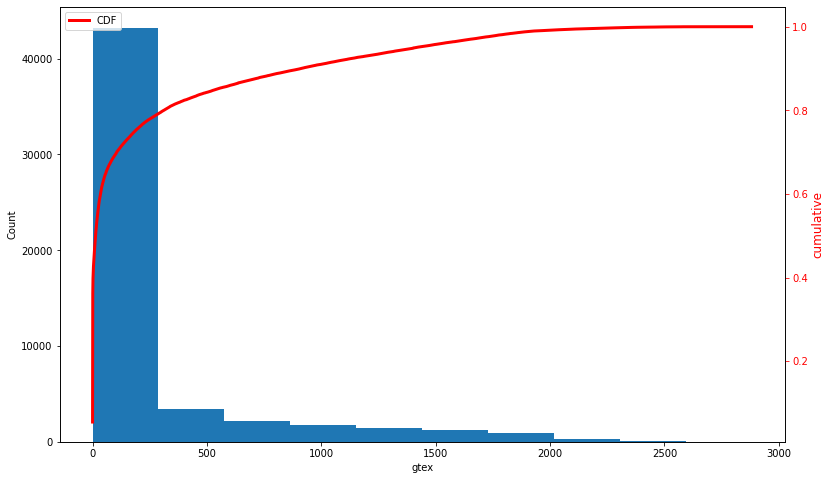

In [16]:
%matplotlib inline
fig,axs= plt.subplots(figsize=(13,8))
data=np.array(list_gtex_corr)  
# getting data of the histogram
count, bins_count = np.histogram(data, bins=np.arange(0,max(data),1))
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.hist(data)
plt.ylabel('Count')
plt.xlabel('gtex')

ax=plt.twinx()

#plt.plot(bins_count[1:], pdf, color="red", label="PDF")
ax.plot(cdf, label="CDF",color='red',linewidth=3)
ax.set_ylabel('cumulative', color='red',fontsize=12)
ax.tick_params(axis="y", colors="red")
plt.legend()

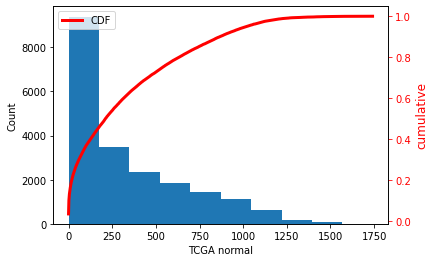

In [17]:
%matplotlib inline
data=np.array(list_tcga_normal_all_corr)  
# getting data of the histogram
count, bins_count = np.histogram(data, bins=np.arange(0,max(data),1))
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.hist(data)
plt.ylabel('Count')
plt.xlabel('TCGA normal')
ax=plt.twinx()

#plt.plot(bins_count[1:], pdf, color="red", label="PDF")
ax.plot(cdf, label="CDF",color='red',linewidth=3)
ax.set_ylabel('cumulative', color='red',fontsize=12)
ax.tick_params(axis="y", colors="red")

plt.legend()

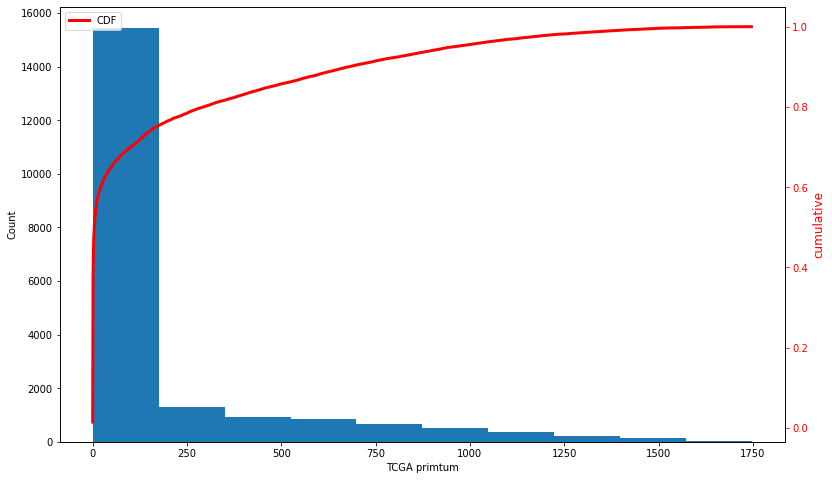

In [18]:
%matplotlib inline
fig,axs= plt.subplots(figsize=(13,8))
data=np.array(list_tcga_primtum_all_corr)  
# getting data of the histogram
count, bins_count = np.histogram(data, bins=np.arange(0,max(data),1))
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.hist(data)
plt.ylabel('Count')
plt.xlabel('TCGA primtum')
ax=plt.twinx()

#plt.plot(bins_count[1:], pdf, color="red", label="PDF")
ax.plot(cdf, label="CDF",color='red',linewidth=3)
ax.set_ylabel('cumulative', color='red',fontsize=12)
ax.tick_params(axis="y", colors="red")

plt.legend()

# formally do all integrins, tables 1,2 and 3 using the functions

In [19]:
#table 1
integrins_list=['ITGA7','ITGB8','ITGB6','ITGA10','ITGA6','ITGA4','ITGAV','ITGA9','ITGB5','ITGA1','ITGA2','ITGA8',
'ITGB1','ITGB7','ITGA5','ITGBL1','ITGA11','ITGAL','ITGAM','ITGAX','ITGAD','ITGAE','ITGA2B','ITGB3','ITGA3',
                'ITGB4','ITGB2']


correlation_method ='pearson'
gtex_gct_dataset = './gene_tpm_2017-06-05_v8_prostate.gct'
correlation_cutoff = 0.6
tcga_hiseq_dataset = 'TCGA.PRAD.sampleMap_HiSeqV2' 
tcga_hiseq_corresponding_sample_info = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGAXena/TCGA.PRAD.sampleMap/PRAD_clinicalMatrix'
opposing_corr_cutoff = 0.1


# make_data_presentable(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
#                          tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)

for interest_gene in integrins_list:
    organize_gtex_tcga_table1(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                             tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)



for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGA7,576,55.381944(319),39.062500(225),35.243056(203)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGB8,202,5.940594(12),1.980198(4),0.990099(2)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGB6,422,20.853081(88),16.113744(68),10.189573(43)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGA10,0,nan(0),nan(0),nan(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGA6,155,26.451613(41),1.290323(2),0.000000(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGA4,281,60.142349(169),45.195730(127),40.925267(115)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGAV,1525,16.655738(254),7.672131(117),6.098361(93)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGA9,906,38.852097(352),31.125828(282),25.938190(235)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGB5,8,12.500000(1),0.000000(0),0.000000(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGA1,1263,39.350752(497),22.961203(290),19.873317(251)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGA2,173,12.138728(21),3.468208(6),2.312139(4)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGA8,184,33.695652(62),30.434783(56),19.565217(36)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGB1,1027,28.334956(291),12.658228(130),8.373905(86)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGB7,310,6.129032(19),32.258065(100),3.548387(11)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGA5,400,41.000000(164),28.500000(114),25.750000(103)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGBL1,30,26.666667(8),33.333333(10),16.666667(5)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGA11,13,38.461538(5),69.230769(9),30.769231(4)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGAL,347,52.161383(181),57.348703(199),47.262248(164)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGAM,260,66.153846(172),67.692308(176),60.000000(156)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGAX,107,83.177570(89),80.373832(86),73.831776(79)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGAD,0,nan(0),nan(0),nan(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGAE,292,9.931507(29),2.739726(8),1.027397(3)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGA2B,349,6.590258(23),0.859599(3),0.573066(2)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGB3,330,20.000000(66),21.818182(72),14.545455(48)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGA3,217,8.755760(19),10.138249(22),3.686636(8)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGB4,259,19.305019(50),10.424710(27),7.335907(19)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGB2,274,68.248175(187),66.423358(182),61.313869(168)


In [20]:
#table 2
integrins_list=['ITGA7','ITGB8','ITGB6','ITGA10','ITGA6','ITGA4','ITGAV','ITGA9','ITGB5','ITGA1','ITGA2','ITGA8',
'ITGB1','ITGB7','ITGA5','ITGBL1','ITGA11','ITGAL','ITGAM','ITGAX','ITGAD','ITGAE','ITGA2B','ITGB3','ITGA3',
                'ITGB4','ITGB2']

correlation_method ='pearson'
gtex_gct_dataset = './gene_tpm_2017-06-05_v8_prostate.gct'
correlation_cutoff = 0.6
tcga_hiseq_dataset = 'TCGA.PRAD.sampleMap_HiSeqV2' 
tcga_hiseq_corresponding_sample_info = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGAXena/TCGA.PRAD.sampleMap/PRAD_clinicalMatrix'
opposing_corr_cutoff = 0.1

# make_data_presentable(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
#                          tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)

for interest_gene in integrins_list:
    organize_gtex_tcga_table2(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)



for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGA7,576,1.562500(9),9.548611(55)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGB8,202,27.227723(55),5.445545(11)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGB6,422,6.635071(28),17.535545(74)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGA10,0,nan(0),nan(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGA6,155,10.322581(16),18.064516(28)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGA4,281,1.779359(5),1.779359(5)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGAV,1525,20.000000(305),16.983607(259)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGA9,906,6.843267(62),10.044150(91)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGB5,8,25.000000(2),25.000000(2)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGA1,1263,5.463183(69),13.222486(167)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGA2,173,27.745665(48),28.901734(50)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGA8,184,4.347826(8),5.434783(10)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGB1,1027,9.737098(100),16.163583(166)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGB7,310,4.838710(15),4.193548(13)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGA5,400,3.000000(12),17.250000(69)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGBL1,30,0.000000(0),3.333333(1)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGA11,13,0.000000(0),0.000000(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGAL,347,2.017291(7),0.576369(2)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGAM,260,3.076923(8),1.923077(5)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGAX,107,1.869159(2),0.000000(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGAD,0,nan(0),nan(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGAE,292,14.726027(43),27.397260(80)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGA2B,349,18.911175(66),9.455587(33)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGB3,330,21.818182(72),20.606061(68)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGA3,217,16.129032(35),32.258065(70)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGB4,259,8.108108(21),31.660232(82)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGB2,274,4.014599(11),1.094891(3)


In [19]:
#table 3
integrins_list=['ITGA7','ITGB8','ITGB6','ITGA10','ITGA6','ITGA4','ITGAV','ITGA9','ITGB5','ITGA1','ITGA2','ITGA8',
'ITGB1','ITGB7','ITGA5','ITGBL1','ITGA11','ITGAL','ITGAM','ITGAX','ITGAD','ITGAE','ITGA2B','ITGB3','ITGA3',
                'ITGB4','ITGB2']

correlation_method ='pearson'
gtex_gct_dataset = './gene_tpm_2017-06-05_v8_prostate.gct'
correlation_cutoff = 0.6
tcga_hiseq_dataset = 'TCGA.PRAD.sampleMap_HiSeqV2' 
tcga_hiseq_corresponding_sample_info = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGAXena/TCGA.PRAD.sampleMap/PRAD_clinicalMatrix'
opposing_corr_cutoff = 0.1

# make_data_presentable(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
#                          tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)

for interest_gene in integrins_list:
    organize_no_overlap_table3(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)



for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGA7,89.33 + 68.74,576,881,812


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGB8,11.87 + 8.16,202,212,196


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGB6,7.55 + 8.15,422,306,256


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGA10,10.80 + 9.75,0,23,0


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGA6,43.58 + 23.71,155,439,43


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGA4,1.91 + 1.48,281,1124,619


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGAV,29.20 + 13.94,1525,706,232


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGA9,13.83 + 9.43,906,1337,879


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGB5,67.05 + 18.24,8,161,0


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGA1,39.66 + 27.60,1263,1126,651


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGA2,11.02 + 9.56,173,381,277


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGA8,39.13 + 63.02,184,722,596


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGB1,99.20 + 86.15,1027,831,254


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGB7,2.37 + 2.28,310,165,436


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGA5,233.37 + 247.60,400,501,380


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGBL1,4.55 + 6.56,30,79,43


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGA11,8.29 + 6.30,13,136,166


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGAL,5.63 + 5.45,347,800,589


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGAM,4.23 + 3.18,260,856,637


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGAX,8.71 + 9.29,107,719,421


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGAD,0.14 + 0.14,0,0,2


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGAE,9.27 + 2.47,292,253,92


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGA2B,2.11 + 1.52,349,605,14


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGB3,8.12 + 10.05,330,737,758


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGA3,66.15 + 37.70,217,74,297


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGB4,87.85 + 49.62,259,298,529


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGB2,12.48 + 10.89,274,1003,595


In [20]:
#just putting the same functions as above in this cell so there's not too many input variables. creating table 4
#below helper functions (i.e. all except the last one) have some modifications and only apply to table 4
#helper functions also appear above in jp notebook so don't touch those
def cutoff_applied_totcga_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,gtex_dataset,other_dataset,first_dataset_name):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    gtex_dataset=correlation_selected_gene(gtex_dataset,interest_gene,correlation_method)
    dataset2=correlation_selected_gene(other_dataset,interest_gene,correlation_method)
    dataset2 = dataset2[dataset2>=correlation_cutoff]
    common_gene_list= gtex_dataset.index.intersection(dataset2.index)
    global new_dataset    
    new_dataset = pd.concat([gtex_dataset[common_gene_list],dataset2[common_gene_list]],axis=1)
#    first_dataset_name = 'gtex_all'
    other_dataset_name='tcga_primtum_all_cutoffmet'
    new_dataset.columns=[first_dataset_name,other_dataset_name]
    print("1st: high cutoff applied to tcga dataset\n2nd: common genes identified with gtex dataset\n3rd: both datasets combined\n4th: low cutoff applied to gtex dataset")

    new_dataset = new_dataset[new_dataset[first_dataset_name]<=opposing_corr_cutoff]
    dict_pd_df = pd.DataFrame(data=[[new_dataset.shape[0],new_dataset.shape[0]]],
                             index=[f'corr_with_{interest_gene}_both_same_genes'],
                             columns=[first_dataset_name,other_dataset_name])
    return dict_pd_df
def cutoff_applied_totcga_2_high_both(interest_gene,correlation_method,correlation_cutoff,gtex_dataset,other_dataset):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    gtex_dataset=correlation_selected_gene(gtex_dataset,interest_gene,correlation_method)
    dataset2=correlation_selected_gene(other_dataset,interest_gene,correlation_method)
    dataset2 = dataset2[dataset2>=correlation_cutoff]
    common_gene_list= gtex_dataset.index.intersection(dataset2.index)
    global new_dataset    
    new_dataset = pd.concat([gtex_dataset[common_gene_list],dataset2[common_gene_list]],axis=1)
    first_dataset_name = 'gtex_all'
    other_dataset_name='tcga_primtum_all_cutoffmet'
    new_dataset.columns=[first_dataset_name,other_dataset_name]
    print("1st: high cutoff applied to tcga dataset\n2nd: common genes identified with gtex dataset\n3rd: both datasets combined\n4th: High cutoff applied to gtex dataset")

    new_dataset = new_dataset[new_dataset[first_dataset_name]>=correlation_cutoff]
    dict_pd_df = pd.DataFrame(data=[[new_dataset.shape[0],new_dataset.shape[0]]],
                             index=[f'high_corr_with_{interest_gene}_both_same_genes'],
                             columns=[first_dataset_name,other_dataset_name])
    return dict_pd_df
def count_high_corr_genes_no_overlap(interest_gene,correlation_method,correlation_cutoff,dataset_name,*processed_datasets):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    print('no overlap between datasets')
    dict_empty={}
    j=0
    for dataset in processed_datasets:
        dataset=correlation_selected_gene(dataset,interest_gene,correlation_method)
        dict_empty[dataset_name]=dataset[dataset>=correlation_cutoff].shape[0]
        
        j+=1
    
    dict_pd_df = pd.DataFrame(dict_empty,index=[f'HIGHLY_correlated_with_{interest_gene}'])
    #return display(HTML(dict_pd_df.to_html()))
    return dict_pd_df


#table 4
integrins_list=['ITGA7','ITGB8','ITGB6','ITGA10','ITGA6','ITGA4','ITGAV','ITGA9','ITGB5','ITGA1','ITGA2','ITGA8',
'ITGB1','ITGB7','ITGA5','ITGBL1','ITGA11','ITGAL','ITGAM','ITGAX','ITGAD','ITGAE','ITGA2B','ITGB3','ITGA3',
                'ITGB4','ITGB2']

correlation_method ='pearson'
gtex_gct_dataset = './gene_tpm_2017-06-05_v8_prostate.gct'
correlation_cutoff = 0.6
tcga_hiseq_dataset = 'TCGA.PRAD.sampleMap_HiSeqV2' 
tcga_hiseq_corresponding_sample_info = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGAXena/TCGA.PRAD.sampleMap/PRAD_clinicalMatrix'
opposing_corr_cutoff = 0.1

for interest_gene in integrins_list:
    organize_tcga_gtex_table4(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                             tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)




its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGA7,812,2.709360(22),6.773399(55),27.709360(225)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGB8,196,19.387755(38),6.122449(12),2.040816(4)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGB6,256,1.171875(3),6.250000(16),26.562500(68)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in long_scalars


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGA10,0,nan(0),nan(0),nan(0)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGA6,43,4.651163(2),0.000000(0),4.651163(2)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGA4,619,3.392569(21),1.130856(7),20.516963(127)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGAV,232,0.862069(2),2.586207(6),50.431034(117)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGA9,879,0.682594(6),8.077361(71),32.081911(282)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in long_scalars


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGB5,0,nan(0),nan(0),nan(0)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGA1,651,1.228879(8),2.304147(15),44.546851(290)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGA2,277,3.249097(9),24.909747(69),2.166065(6)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGA8,596,2.013423(12),11.241611(67),9.395973(56)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGB1,254,1.181102(3),1.574803(4),51.181102(130)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGB7,436,2.293578(10),3.440367(15),22.935780(100)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGA5,380,1.052632(4),5.789474(22),30.000000(114)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGBL1,43,0.000000(0),2.325581(1),23.255814(10)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGA11,166,3.012048(5),0.000000(0),5.421687(9)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGAL,589,4.244482(25),2.716469(16),33.786078(199)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGAM,637,2.668760(17),0.627943(4),27.629513(176)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGAX,421,1.662708(7),0.712589(3),20.427553(86)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGAD,2,50.000000(1),0.000000(0),0.000000(0)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGAE,92,5.434783(5),1.086957(1),8.695652(8)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGA2B,14,0.000000(0),0.000000(0),21.428571(3)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGB3,758,1.055409(8),15.435356(117),9.498681(72)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGA3,297,12.457912(37),19.191919(57),7.407407(22)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGB4,529,8.695652(46),21.361059(113),5.103970(27)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGB2,595,4.033613(24),1.848739(11),30.588235(182)
